In [22]:
!git clone https://github.com/atikul-islam-sajib/TreeBasedModel.git

In [1]:
%cd TreeBasedModel

/Users/loecherm/Nextcloud2/SHKs/Atikul/TreeBasedModel


In [22]:
!pip install shap

In [2]:
!pip install -e .

Obtaining file:///Users/loecherm/Nextcloud2/SHKs/Atikul/TreeBasedModel
  Preparing metadata (setup.py) ... done
  Attempting uninstall: AugmentedHierarchicalShrinkage
    Found existing installation: AugmentedHierarchicalShrinkage 1
    Uninstalling AugmentedHierarchicalShrinkage-1:
      Successfully uninstalled AugmentedHierarchicalShrinkage-1
  Running setup.py develop for AugmentedHierarchicalShrinkage

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Task ?

specified that I do not intend to optimize the parameter \( k \) this time, but rather to document the results for each value of \( k \). Specifically, goal is to visualize importance measures—MDI and SHAP included—as functions of \( k \), while keeping the `max_features` parameter at its default setting. There is no need to optimize for ROC AUC scores; however, want these scores recorded for each \( k \). Furthermore, for each level of feature relevance, aim to produce a set of four plots that illustrate these metrics.

In [3]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from TreeModelsFromScratch.RandomForest import RandomForest
from utils import simulate_data_strobl
from matplotlib import pyplot as plt

In [4]:
relevance=0.1
depth_dof=True
k=9
roc_aucs, mdi_importances, shap_values_all = [], [], []

In [5]:
iterations=10
for _ in range(iterations):
    #generate data
    X, y = simulate_data_strobl(n=300, relevance=relevance)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    model = RandomForest(treetype="classification", n_trees=25, k=k, oob_SHAP=True, depth_dof=depth_dof)
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:, 1]
    roc_aucs.append(roc_auc_score(y_test, y_scores))
    mdi_importances.append(model.feature_importances_)
    shap_values_all.append(np.mean(np.abs(model.oob_SHAP_values), axis=0))


In [38]:
#results = {"depth_dof_True": {"roc" : roc_aucs, "mdi_importances":mdi_importances, "shap_values_all":shap_values_all} }
results["depth_dof_False"] = {"roc" : roc_aucs, "mdi_importances":mdi_importances, "shap_values_all":shap_values_all} 

In [6]:
print(roc_aucs)
print(mdi_importances)
print(shap_values_all)
#results = {"depth_dof_True": {"roc" : roc_aucs, "mdi_importances":mdi_importances, "shap_values_all":shap_values_all} }

[0.5108759553203998, 0.6425037110341415, 0.5415635823849579, 0.6072874493927125, 0.47064935064935065, 0.6314731020613373, 0.5157499999999999, 0.6672952586206897, 0.5963793982661907, 0.6505926724137931]
[array([ 0.11776274,  0.12702487,  0.34370982,  0.26669554, -0.13519297]), array([-0.30663402,  0.41769545,  0.25867543,  0.44647024, -0.0562071 ]), array([-0.24525111,  0.49018933,  0.11026898,  0.40131642,  0.16347637]), array([ 0.0727117 ,  0.47343216, -0.00657018, -0.01574416,  0.23617049]), array([0.31044197, 0.05490949, 0.08651866, 0.12114292, 0.34698696]), array([0.05174623, 0.20387435, 0.12617765, 0.07850514, 0.05969662]), array([ 2.99871942, -0.60176197, -1.46625315, -0.22639093,  0.13568663]), array([ 0.70997575,  0.22663651, -0.13921635,  0.07728957,  0.12531452]), array([0.06632175, 0.27947777, 0.21340344, 0.0465632 , 0.35423385]), array([ -0.81017967,  20.09033709,   0.96530485, -28.62569404,
         9.34023176])]
[array([0.00813279, 0.0067771 , 0.01138944, 0.0093737 , 0.02

In [41]:
results.keys()

dict_keys(['depth_dof_True', 'depth_dof_False'])

In [22]:
mdi_feature_means = np.zeros(5)
for i, mdi in enumerate(mdi_importances):
    #print(mdi)
    mdi_feature_means += mdi

mdi_feature_means /= (i+1)


In [23]:
print(i)
mdi_feature_means

4


array([ 0.27512803,  0.07266655,  0.20050511, -0.69170109,  0.93540139])

In [32]:
type(mdi_importances)
np.array(mdi_importances).shape
np.mean(mdi_importances, axis=0)

array([ 0.42455645,  0.06648382,  0.19382475, -0.03932703,  0.122462  ])

#### With K and Max Feature = Default - Custom RF

In [18]:
def calculate_auc_roc(y_true, y_scores):
    """Calculate the AUC-ROC score."""
    return roc_auc_score(y_true, y_scores)

def evaluate_models(X_train, y_train, X_test, y_test, k_values, iterations=20, depth_dof=False):
    """Evaluate RandomForest models for a range of k values and record MDI, SHAP, and ROC AUC over specified iterations."""
    results = []
    for k in k_values:
        roc_aucs, mdi_importances, shap_values_all = [], [], []
        for _ in range(iterations):
            model = RandomForest(treetype="classification", n_trees=25, k=k, random_state=42, oob_SHAP=True, depth_dof=depth_dof)
            model.fit(X_train, y_train)
            y_scores = model.predict_proba(X_test)[:, 1]
            roc_aucs.append(calculate_auc_roc(y_test, y_scores))
            mdi_importances.append(model.feature_importances_)
            shap_values_all.append(np.mean(np.abs(model.oob_SHAP_values), axis=0))

        results.append({
            'k': k,
            'roc_auc': np.mean(roc_aucs),
            'mdi_importances': np.mean(mdi_importances, axis=0),
            'shap_values': np.mean(shap_values_all, axis=0)
        })
    return results

In [19]:
relevance_values = [0, 0.05, 0.1, 0.15, 0.2]
k_values = range(1, 31)
all_results = []

for relevance in relevance_values:
    X, y = simulate_data_strobl(n=300, relevance=relevance, seed=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    results = evaluate_models(X_train, y_train, X_test, y_test, k_values, iterations=20, depth_dof=False) # Iteration 20, depth = False
    all_results.append({'relevance': relevance, 'results': results})

# Save results to a pickle file
with open('evaluation_results.pkl', 'wb') as file:
    pickle.dump(all_results, file)

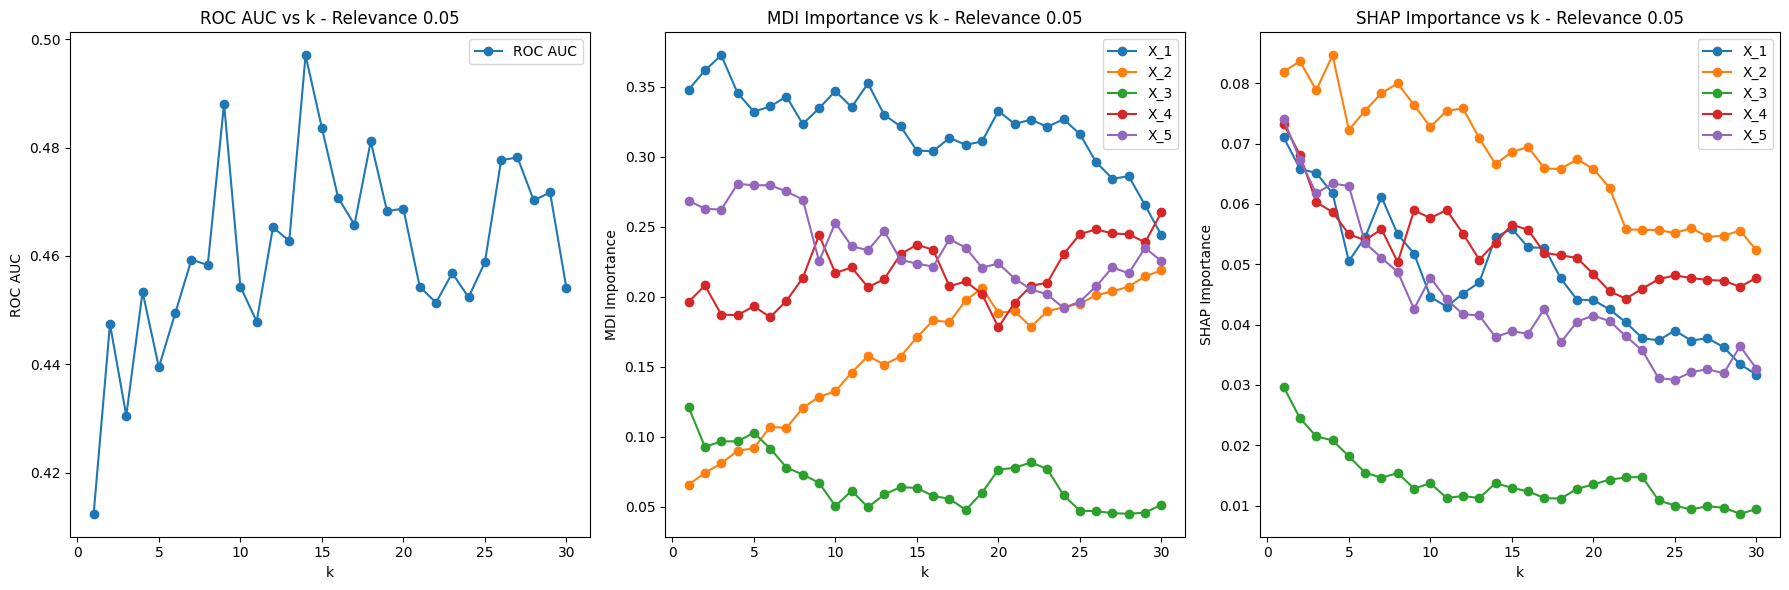

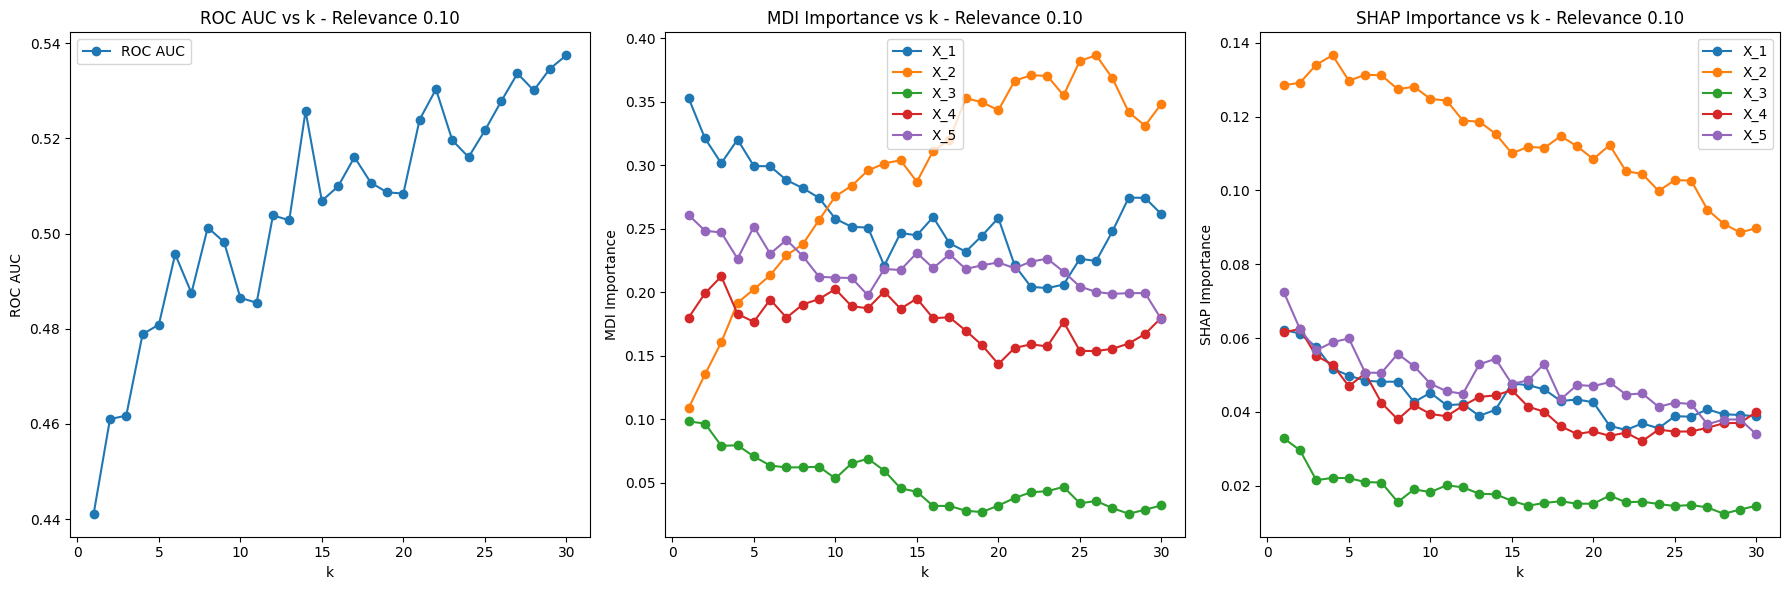

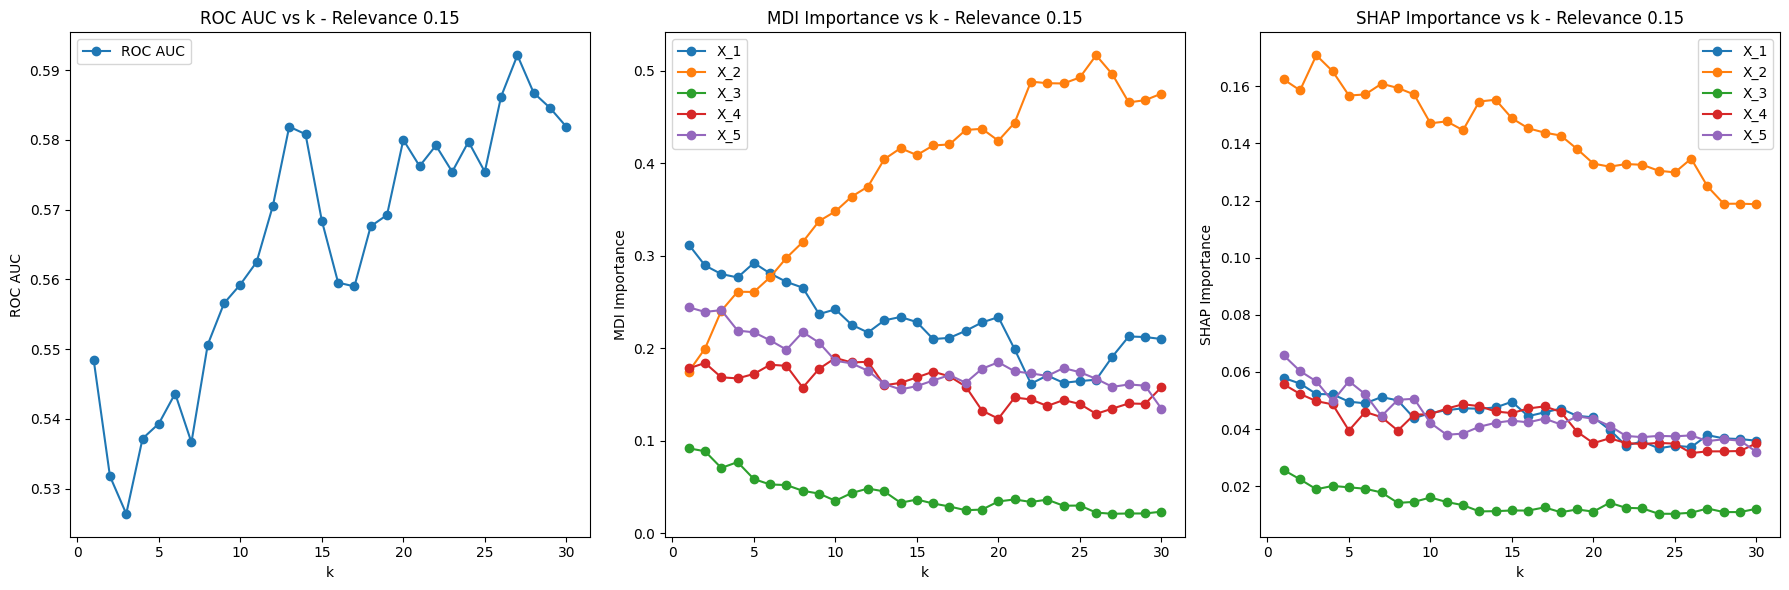

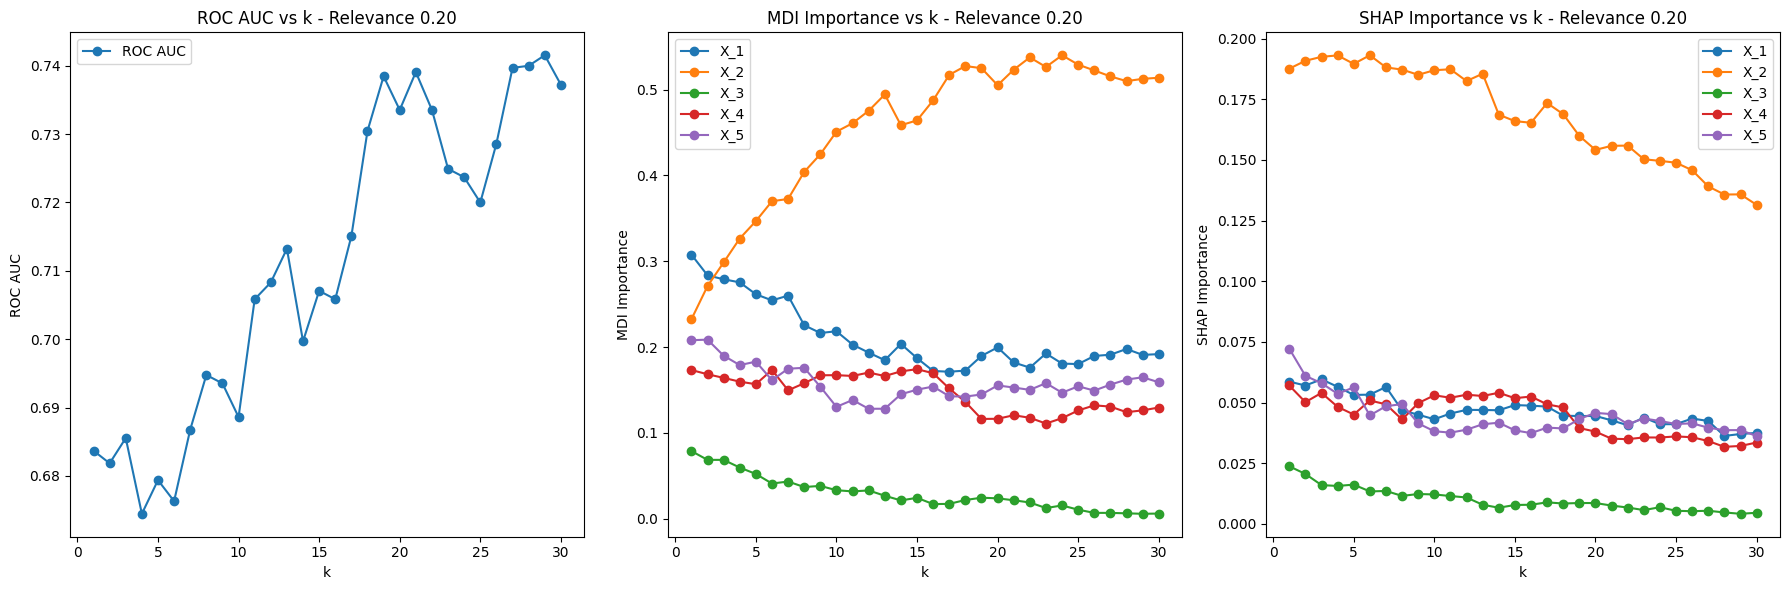

In [20]:
# Plotting results with revised legends and titles
for relevance_result in all_results:
    relevance = relevance_result['relevance']
    plt.figure(figsize=(18, 6))

    ks = [result['k'] for result in relevance_result['results']]
    rocs = [result['roc_auc'] for result in relevance_result['results']]
    mdi_importances = [result['mdi_importances'] for result in relevance_result['results']]
    shap_importances = [result['shap_values'] for result in relevance_result['results']]

    plt.subplot(1, 3, 1)
    plt.plot(ks, rocs, label=f'ROC AUC', marker="o")
    plt.title(f'ROC AUC vs k - Relevance {relevance:.2f}')
    plt.xlabel('k')
    plt.ylabel('ROC AUC')
    plt.legend()

    plt.subplot(1, 3, 2)
    for feature_idx in range(mdi_importances[0].shape[0]):
        mdi_feature_means = [mdi[feature_idx] for mdi in mdi_importances]
        plt.plot(ks, mdi_feature_means, label=f'X_{feature_idx + 1}', marker="o")
    plt.title(f'MDI Importance vs k - Relevance {relevance:.2f}')
    plt.xlabel('k')
    plt.ylabel('MDI Importance')
    plt.legend()

    plt.subplot(1, 3, 3)
    for feature_idx in range(shap_importances[0].shape[0]):
        shap_feature_means = [shap[feature_idx] for shap in shap_importances]
        plt.plot(ks, shap_feature_means, label=f'X_{feature_idx + 1}', marker="o")
    plt.title(f'SHAP Importance vs k - Relevance {relevance:.2f}')
    plt.xlabel('k')
    plt.ylabel('SHAP Importance')
    plt.legend()

    plt.tight_layout()
    plt.show()

### With Depth and K - > depth = True

In [21]:
relevance_values = [0, 0.05, 0.1, 0.15, 0.2]
k_values = range(1, 31)
all_results = []

for relevance in relevance_values:
    X, y = simulate_data_strobl(n=300, relevance=relevance, seed=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    results = evaluate_models(X_train, y_train, X_test, y_test, k_values, depth_dof=True, iterations=20) # Iteration 20, depth_dof = True
    all_results.append({'relevance': relevance, 'results': results})

# Save results to a pickle file
with open('evaluation_results_depth_true.pkl', 'wb') as file:
    pickle.dump(all_results, file)

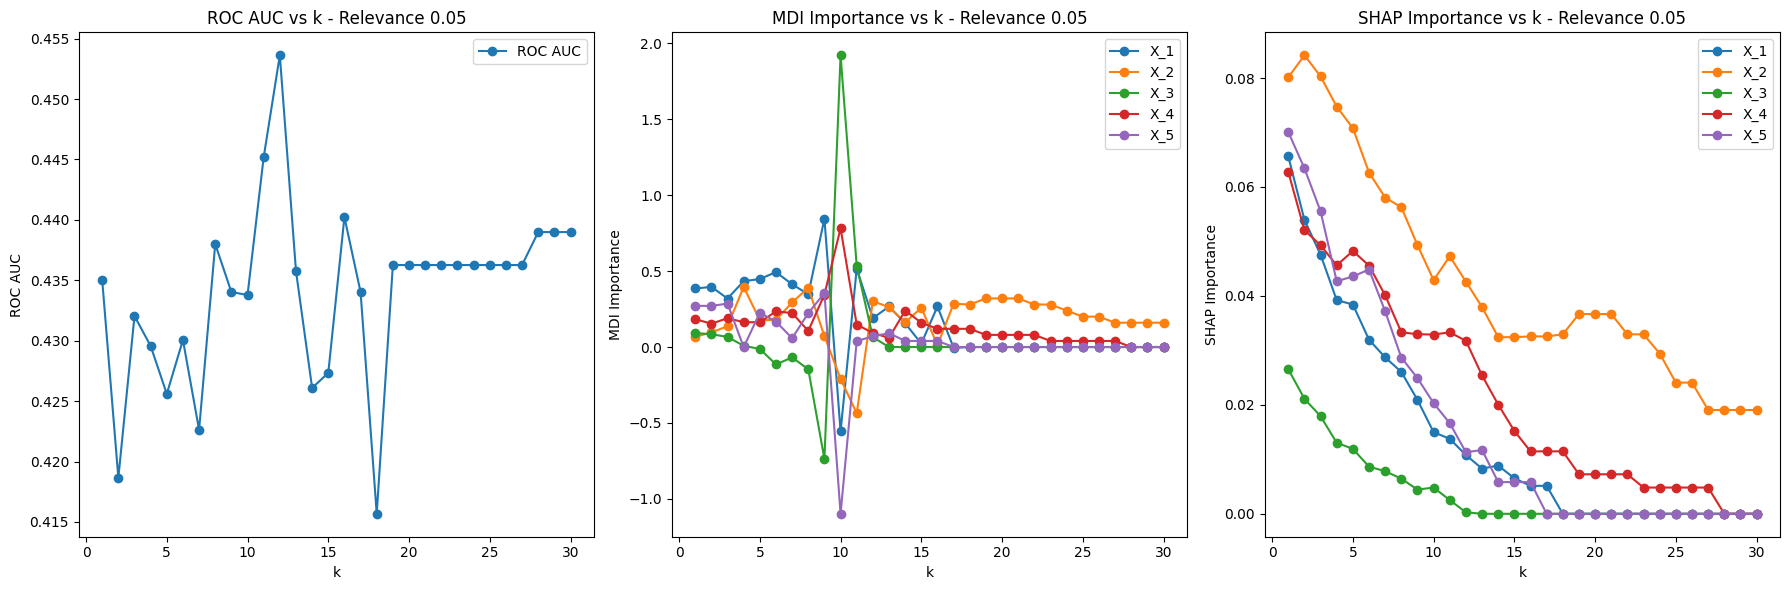

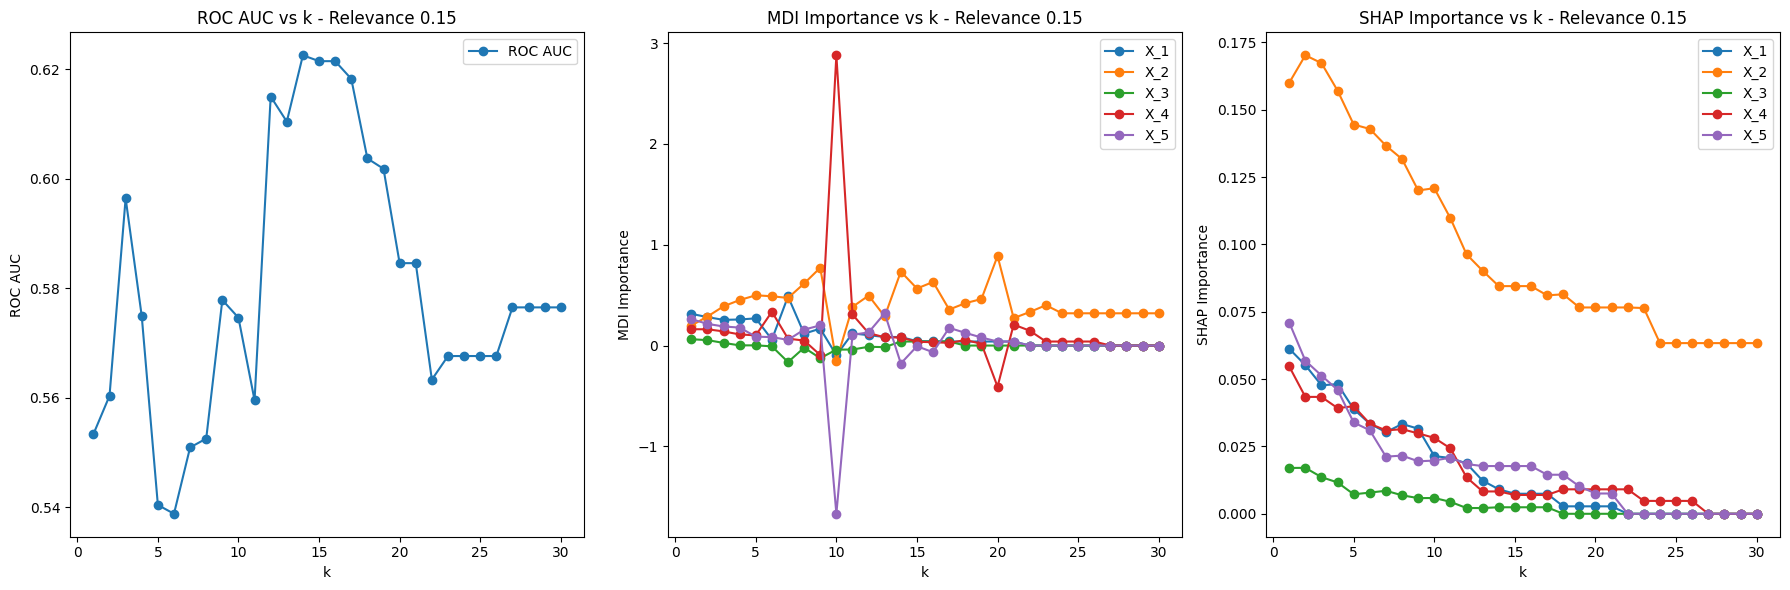

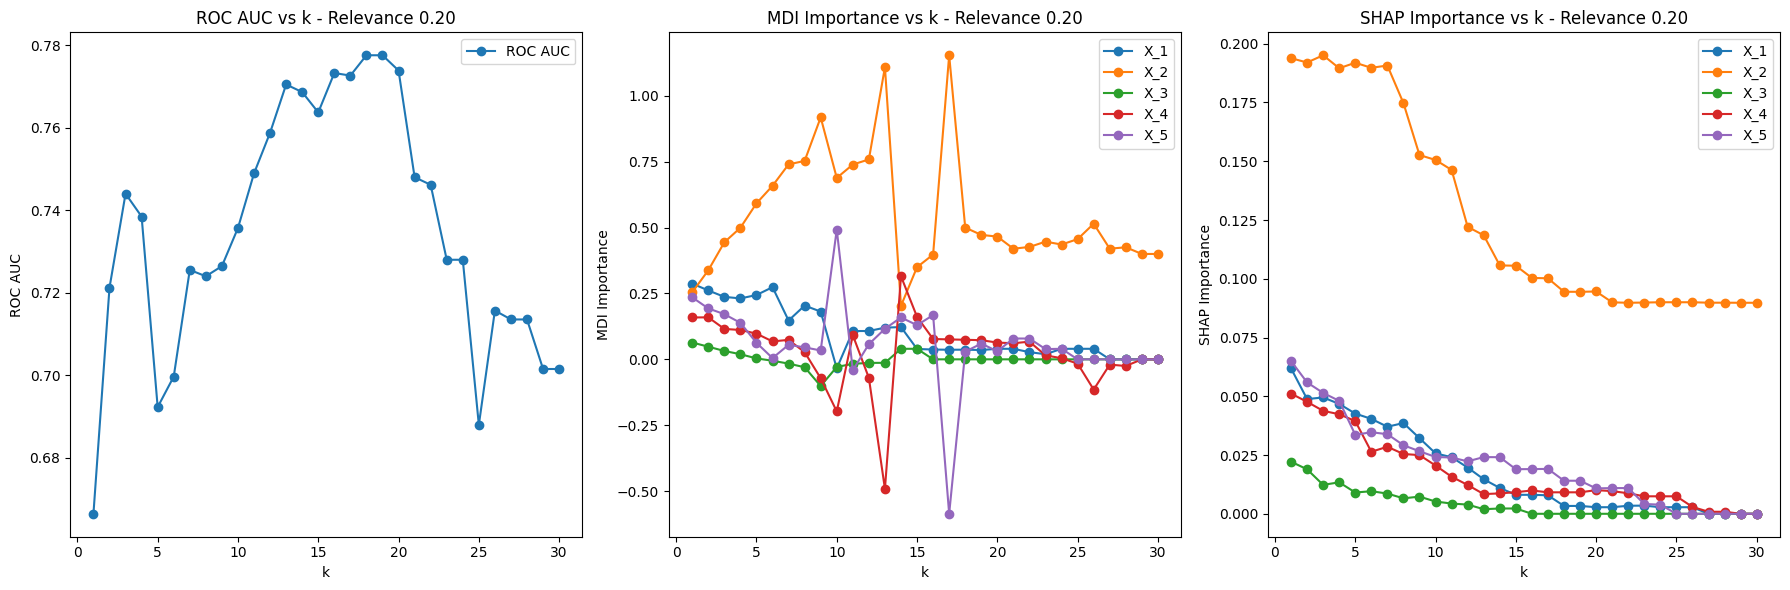

In [22]:
# Plotting results with revised legends and titles
for relevance_result in all_results:
    relevance = relevance_result['relevance']
    plt.figure(figsize=(18, 6))

    ks = [result['k'] for result in relevance_result['results']]
    rocs = [result['roc_auc'] for result in relevance_result['results']]
    mdi_importances = [result['mdi_importances'] for result in relevance_result['results']]
    shap_importances = [result['shap_values'] for result in relevance_result['results']]

    plt.subplot(1, 3, 1)
    plt.plot(ks, rocs, label=f'ROC AUC', marker="o")
    plt.title(f'ROC AUC vs k - Relevance {relevance:.2f}')
    plt.xlabel('k')
    plt.ylabel('ROC AUC')
    plt.legend()

    plt.subplot(1, 3, 2)
    for feature_idx in range(mdi_importances[0].shape[0]):
        mdi_feature_means = [mdi[feature_idx] for mdi in mdi_importances]
        plt.plot(ks, mdi_feature_means, label=f'X_{feature_idx + 1}', marker="o")
    plt.title(f'MDI Importance vs k - Relevance {relevance:.2f}')
    plt.xlabel('k')
    plt.ylabel('MDI Importance')
    plt.legend()

    plt.subplot(1, 3, 3)
    for feature_idx in range(shap_importances[0].shape[0]):
        shap_feature_means = [shap[feature_idx] for shap in shap_importances]
        plt.plot(ks, shap_feature_means, label=f'X_{feature_idx + 1}', marker="o")
    plt.title(f'SHAP Importance vs k - Relevance {relevance:.2f}')
    plt.xlabel('k')
    plt.ylabel('SHAP Importance')
    plt.legend()

    plt.tight_layout()
    plt.show()